In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

# for 3d plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

#%matplotlib inline
#%matplotlib widget
%matplotlib notebook

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 10) # set default figure size, 8in by 6in

In this module, we introduce Principal Components Analysis, and show how it can be used for data compression to speed up learning algorithms as well as for visualizations of complex datasets.

# Video W8 06: Motivation I Data Compression

[YouTube Video Link](https://www.youtube.com/watch?v=h8ri2gbBjIc&index=82&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

This video gives a good intuitive idea of how data compression by reducing dimensions works.  As shown in the video, a 2
dimensional highly redundante (linear) feature can be basically reduced to 1 dimension with almost no loss of information.
This type of reduction of dimensions is very important in practice.  Less dimensions means less features we have for our learning
algorithms.  This reduces the time and effort needed to build models using the features.  


It might seem a bit contrived, but it is really quite common, especially when working with big data, that a lot
of features will have a large bit of overlap.  Such redundant features are often not going to add any predictive
power to a classifier, and are thus best eliminated.

For example, from the video we imagine a data set that has features both measuring the length of some item,
but one was measured in cm and one in inches.

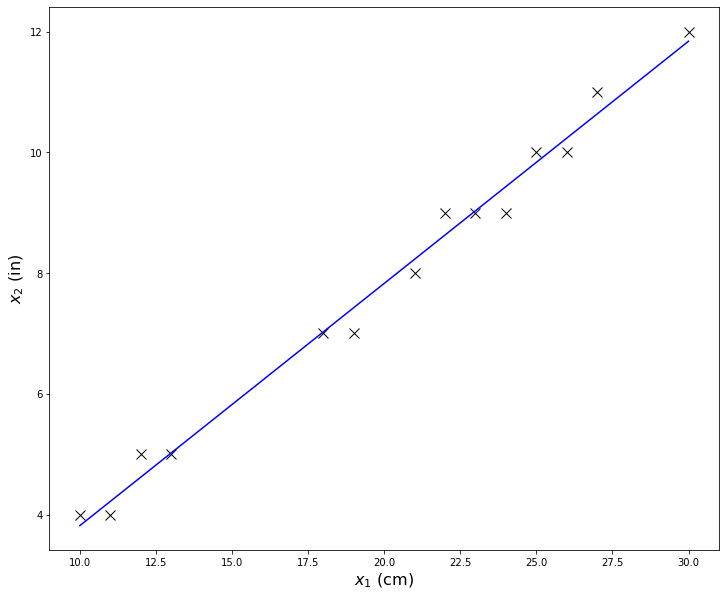

In [3]:
# make some cm measurements at random, from 10 to 30 cm
m = 14
x1 = np.random.choice(np.arange(10, 31), m, replace=False)

# convert to inches and round to nearest inch
x2 = np.round(x1 / 2.54)

#print(x1)
#print(x2)

# plot the points
plt.plot(x1, x2, 'kx', markersize=10)
plt.xlabel('$x_1$ (cm)', fontsize=16)
plt.ylabel('$x_2$ (in)', fontsize=16);

# plot a fitted line to the points
theta = np.polyfit(x1, x2, 1)
h = np.poly1d(theta)
x = np.linspace(10,30,100)
plt.plot(x, h(x), 'b-');

We approximate the original data set by projecting each original point onto the line.

Reduce data from 2D to 1D

\begin{equation}
\begin{split}
x^{(1)} \in \mathbb{R}^2 &\to z^{(1)} \in \mathbb{R} \\
x^{(2)} \in \mathbb{R}^2 &\to z^{(2)} \in \mathbb{R} \\
\vdots \\
x^{(m)} \in \mathbb{R}^2 &\to z^{(m)} \in \mathbb{R} \\
\end{split}
\end{equation}

## Reduce data from 3D to 2D Example

In a typical data reduction/compression we might be doing something more like reducing $1000D \to 100D$
for example.  

When you visualize a projection from 3D to 2D, what will happen is that you will project the data
to a 2-dimensional hyperplane.  

In [4]:
# generate some 3d data by hand in 2 classes, just for this example
mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0.66,0],[0.66,1,0.5],[0,0.5,1]])
X = np.random.multivariate_normal(mu_vec1, cov_mat1, 100)
print(X.shape)

(100, 3)


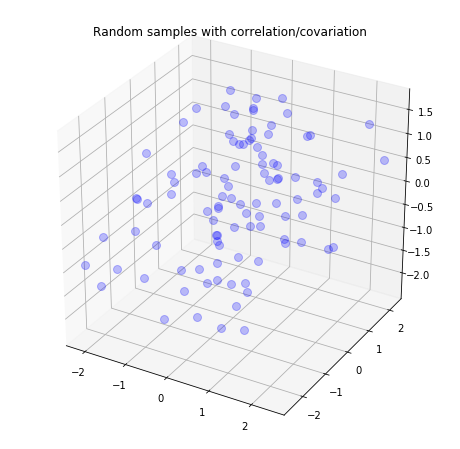

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(X[:, 0], X[:, 1], X[:, 2], 'o', markersize=8, color='blue', alpha=0.25)

plt.title('Random samples with correlation/covariation');


The following example is from [here](https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot) of plotting arrows using eigenvectors calculated from the data.


In [6]:
# matplotlib still doesn't have an arrow patch for drawing vectors, so we add it
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        

<IPython.core.display.Javascript object>


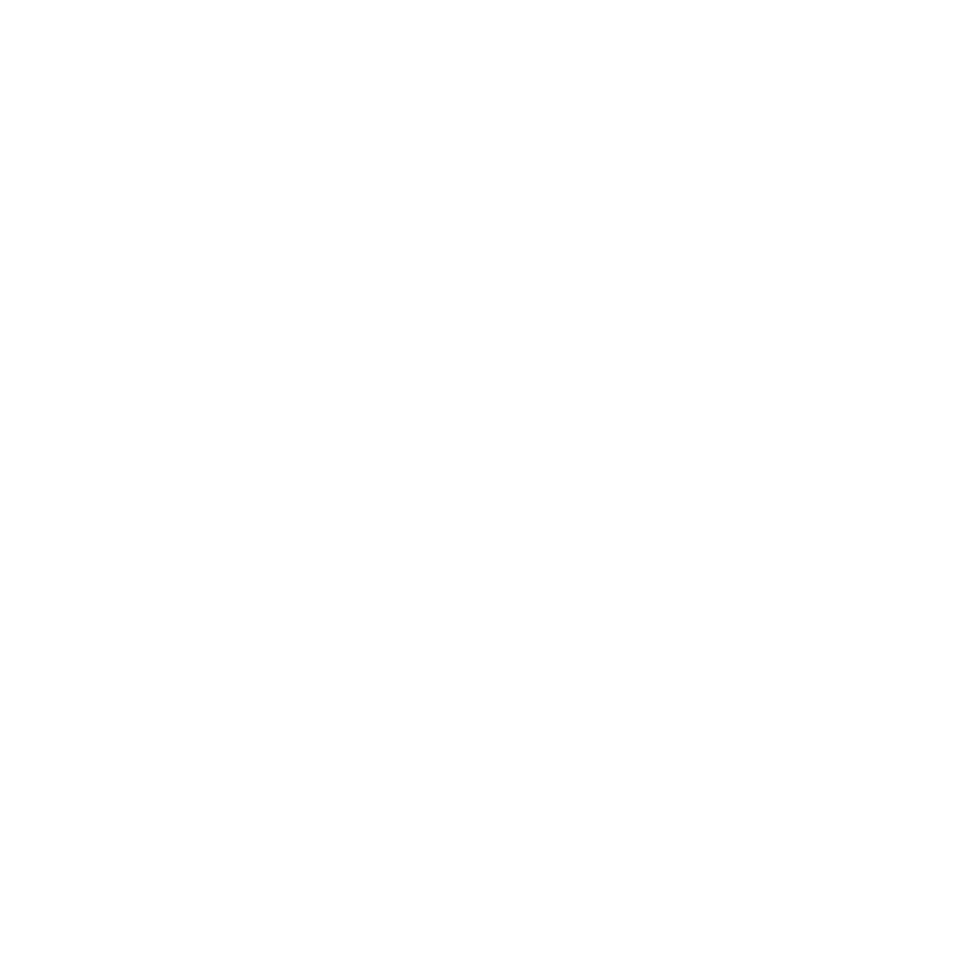

Text(0.5, 0.92, 'Random samples with correlation/covariation and first 2 Eigenvectors')

In [7]:
%matplotlib notebook

# mean values
mean_x = np.mean(X[:,0])
mean_y = np.mean(X[:,1])
mean_z = np.mean(X[:,2])

#eigenvectors and eigenvalues
eig_val, eig_vec = np.linalg.eig(cov_mat1)

################################
#plotting eigenvectors
################################    

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], X[:,2], 'o', markersize=10, color='blue', alpha=0.25)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='green', alpha=0.4)
for d,v in enumerate(eig_vec[:3]):
    #ax.plot([mean_x,v[0]], [mean_y,v[1]], [mean_z,v[2]], color='red', alpha=0.8, lw=3)
    #I will replace this line with:
    v = v * eig_val[d]
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], 
                [mean_z, v[2]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="green")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Random samples with correlation/covariation and first 2 Eigenvectors')


[[-0.48720448 -0.71627642 -0.49957971]
 [ 0.66077295  0.07166614 -0.74715666]]
[1.82498702 0.92293069]
original shape:    (100, 3)
transformed shape: (100, 2)


<IPython.core.display.Javascript object>


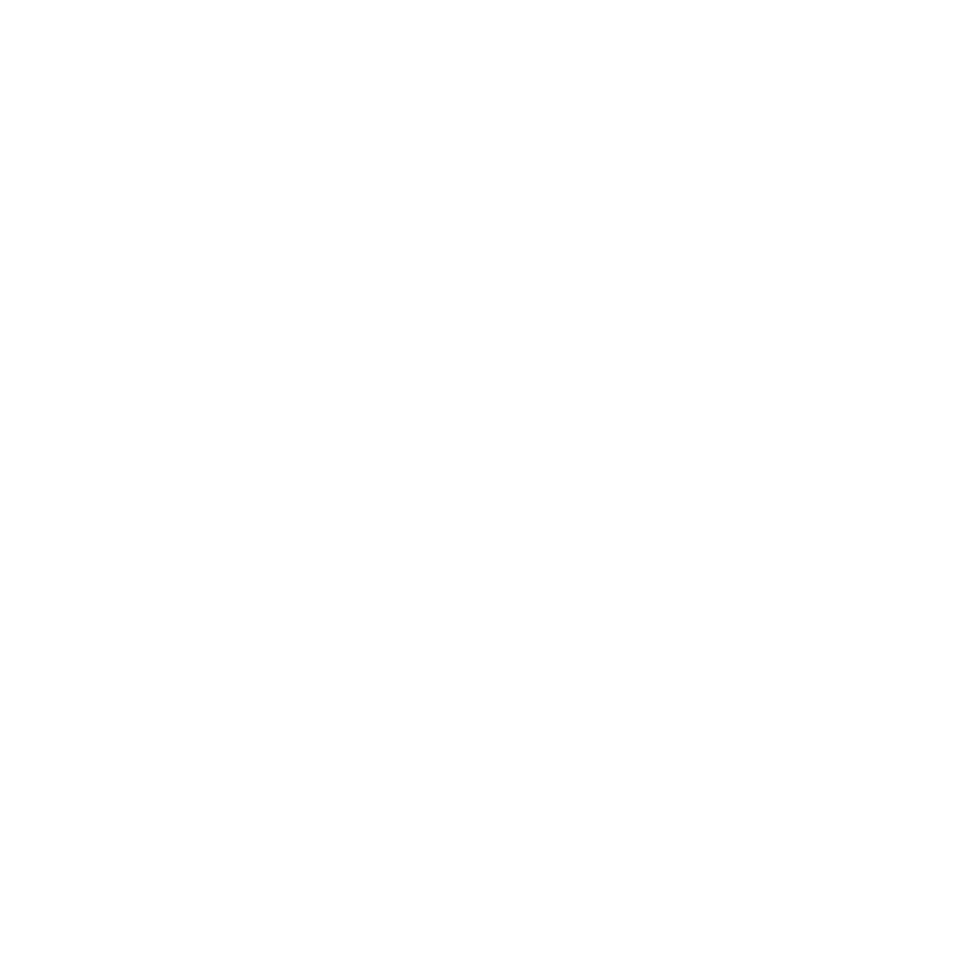

In [8]:
# use PCA to project from 3D to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca.fit(X)
print(pca.components_)
print(pca.explained_variance_)

X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

# plot the 2D projection
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.25)
plt.xlabel('$z_0$', fontsize=16)
plt.ylabel('$z_1$', fontsize=16);

# Video W8 07: Motivation II Data Visualization

[YouTube Video Link](https://www.youtube.com/watch?v=18xeFJZAdMw&index=83&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


Another main use of dimensionality reduction is in order to visualize very high dimensional data in 2
or 3 dimensional space and plots.

The previous plot and subsequent reduction from 3D to 2D was an example.  But for visualization, usually what we
mean is we have a huge set of features, and we want to project down to the most important 2 or 3 features and plot
those features.

Using dimensionality reduction, we can project high dimensional data into a 3D or 2D set of data that we can
then successfully visualize in 3 or 2 dimensions.

When you use PCA, the new features do not directly correspond to any of the original features, so you will need
to infer what they might most directly relate to.  

# Video W8 08: Principal Component Analysis

[YouTube Video Link](https://www.youtube.com/watch?v=aSl7tPE1Pyo&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=84)


The formal method for accomplishing dimensionality reduction through the technique known as Principle Component Analysis (PCA) has
some surface similarity to performing a linear regression.  Intuitively, we are trying to find a lower dimensional hyperplane for our data
to which when we project our original data we minimize the sum squared error of the distances we had to project the data in order
to reduce the dimensionality (the projection error).

Principal Component Analysis (PCA) attempts to find a projection to a lower dimensional hyperplane
that  minimizes the sum squared projection error of the projection of the points onto the new lower 
dimensional hyperplane.  As shown in the example in the video, if our original data is 
$\mathbb{R}^2$ (2 dimensional), the lower dimensional hyperplane is in this case a 1 dimensional line.

PCA is not linear regression.  The cost function is similar, but in PCA we are minimizing the projection
distance to the line/plane, instead of minimizing the distance from the point to the dependent variable we
are trying to predict.

Lets look at a quick example of using PCA.  The following example is taken directly from the
`scikit-learn` library [example on using PCA](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html).

First of all, lets look at a rather famous data set, the Iris dataset.  This data set consists of
only $m = 150$ data points.  The data points are labeled between 3 different species of Iris
flowers (species Virginica, Versicolor and Setosa).  PCA is an unsupervised learning technique, so
we don't need the labels.  Each of the 150 data points has $\mathbb{R}^4$ 4 dimensional measurements associated with it (petal length and width, and sepal length and width).  We of course can't visualze
all 4 dimensions simultaneously, so lets visualize 3 of the 4 data points:  

In [9]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

<IPython.core.display.Javascript object>


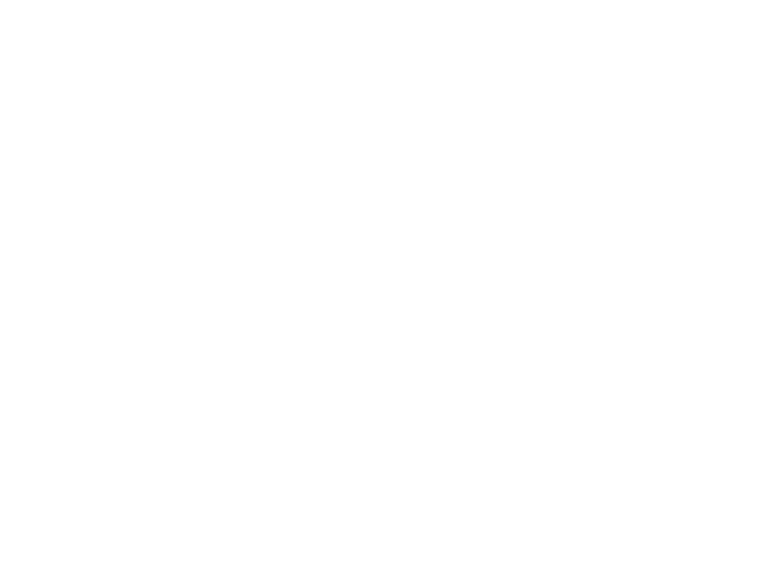

In [10]:
# plot 3 of the 4 dimnsions
fig = plt.figure()
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.jet)

# The data in the 4 dimensions are:
# X[:, 0] = 'sepal length'
# X[:, 1] = 'sepal width'
# X[:, 2] = 'petal length'
# X[:, 3] = 'petal width'
# so if you want the labels on the axis to be correct if you plot different
# dimensions, need to also change these labels.
dims = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
ax.xaxis.set_label_text(dims[0])
ax.yaxis.set_label_text(dims[1])
ax.zaxis.set_label_text(dims[2])

# likewise, we are labeling the type of each of the 3 species clases
# by putting a text label on the feature at the mean.  You would have to
# change the code here ias well to specify which dimensions of X[,?] you are plotting
for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))


I encourage you to try plotting some other combinations of dimensions.  Try using the `%matplotlib notebook`
notebook directive to allow for interactive plots (you may need to install additional libraries/components
to get this to work.

Lets compress the data from 4 dimensions to its 2 principal component dimensions and see the result.

<IPython.core.display.Javascript object>


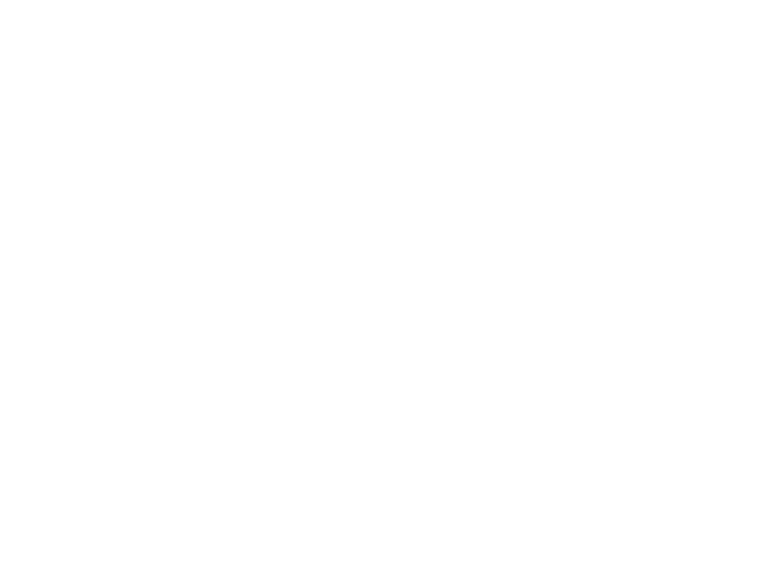

In [11]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

plt.figure()
plt.scatter(X[y==0, 0], X[y==0, 1], c='b', label='Setosa')
plt.scatter(X[y==1, 0], X[y==1, 1], c='g', label='Versicolor')
plt.scatter(X[y==2, 0], X[y==2, 1], c='r', label='Virginica')

plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()

In [12]:
print(pca.components_)
print(pca.explained_variance_ratio_)
print(pca.mean_)

[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
[0.92461872 0.05306648]
[5.84333333 3.05733333 3.758      1.19933333]


So if PCA is working correctly, this represents the 2 dimensions from the original 4 with the least amount of projection error of the original 4 dimensional data.  As you can see, while Setosa is well separated
from the other 2 classes, there is some overlaop in Versicolor and Virginica classes.  

# Video W8 09: Principal Component Analysis Algorithm

[YouTube Video Link](https://www.youtube.com/watch?v=G7HJWzjQNSQ&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=85)

This video starts out by noting that you should always perform mean feature scaling and mean normalization
of the features.  You will notice that in the example I gave above I did not do this by hand.  This is
because the `scikit-learn` PCA library automatically performs the normalization on the
data you give it before running PCA.  You will notice, for example, that the 2 dimensional principal
components are centered at the origin $0, 0$


The video at this point goes into the details of how the PCA algorithm is computed.  As stated in the
video, we won't look at any proofs that these procedures correctly comptue the hyperplanes that
minimize the projection error (it is beyond the scope of our course).  But lets just compute
the PCA by hand using Python functions, and compare our results to the PCA computation obtained
through the `scikit-learn` library.  

As in the previous example, lets continue using the iris data set with 4 dimensions to perform
our example of computing the PCA algorithm:

In [13]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

m, n = X.shape # m training examples, each n dimensional
print(m, "training examples")
print(n, "features/dimensions")

150 training examples
4 features/dimensions


Before when we used PCA from the `scikit-learn` library, it perform feature normalization for us.  But
if we want to do PCA ourself by hand, we need to perform normalization:

$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)}
$$

Where the $\mu_j$ is really the mean for each of the $n$ features of our data.  We replace each
feature $x_j^{(i)}$ with $x_j - \mu_j$ (e.g. we are simply subtracting the mean from each feature).
We can do feature normalization by hand like this:


In [14]:
# we could use loops to calculate the mean of each of the 4 features, but we can
# use a simply numpy operation to get the mean along the appropriate axis
mu = np.mean(X, axis=0)

# we should end up with the mean value of each of our 4 dimensions, compare this to the means
# in the iris dataset documentation to verify
print(mu.shape)
print(mu)

(4,)
[5.84333333 3.05733333 3.758      1.19933333]


Once we have the means of each dimension, we can perform mean normalization.  Again we'll use numpy
operations to subtract the mean for each dimension from each data set item

In [15]:
X_norm = X - mu
print(X_norm.shape)

 # notice that the means are all now basically 0 in our mean normalized data
print(np.mean(X_norm, axis=0))

(150, 4)
[-1.12502600e-15 -7.60872846e-16 -2.55203266e-15 -4.48530102e-16]


To also do the feature scaling, one simple way is to calculate the standard deviation of each of 
our dimensions in the data, then divide the values by this standard deviation.  This has the effect of
scaling the standard deviation of the dimension to be 1.0.  For example, we can do a very similar 
procedure to calculate the sd of each dimension, the perform both normalization and scaling

$$
X_j^{(i)} \leftarrow \frac{X_j^{(i)} - \mu_j}{s_j}
$$

In [16]:
sd =  np.std(X, axis=0)

# we should end up with the standard deviation value of each of our 4 dimensions, again you
# can compare this to the reported sd for each dimension
print(sd.shape)
print(sd)

(4,)
[0.82530129 0.43441097 1.75940407 0.75969263]


In [17]:
X_norm_scaled = (X - mu) / sd
print(X_norm_scaled.shape)

 # notice that the means are all now basically 0 in our mean normalized data
print(np.mean(X_norm_scaled, axis=0))
print(np.std(X_norm_scaled, axis=0))

(150, 4)
[-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
[1. 1. 1. 1.]


So as shown, the final result of normalization and scaling is that all features now have a mean of 0 and
a standard deviation of 1.0.  It appears that the `scikit-learn` PCA only performs mean normalization 
for you on the data you fit.  Thus, in the above cells I created arrays `X_norm` and `X_nrom_scaled`,
but we will only use `X_norm` in the next cells when we recreate the PCA algorithm by hand.

## PCA Algorithm (computing by hand)

**Step 1**: The first step shown in the video to perform the **PCA algorithm** is to compute a "covariance
matrix", that we will name `Sigma`.  The formula for computing the covariance matrix is:

$$
\Sigma = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)}) (x^{(i)})^T
$$

**NOTE**: There is a typo first time this equation is shown in video around time 8:00.  The sum goes over 
the $m$ training input patterns.

We can compute that using Python for a single dimension, like dimension 0, with the following code:

In [18]:
# In python, our dimensions are 0, 1, 2 and 3, so the above formula sums from i = 0 to 3.
# For example, if we start with dimension 0, and we multiple x^(0) x^(0)^T we get
c = np.dot(X_norm[0, :].reshape( (n,1) ), X_norm[0, :].reshape( (n,1) ).T)
print(c.shape)
print(c)

(4, 4)
[[ 0.55254444 -0.32904889  1.75278     0.74283778]
 [-0.32904889  0.19595378 -1.043808   -0.44237156]
 [ 1.75278    -1.043808    5.560164    2.356428  ]
 [ 0.74283778 -0.44237156  2.356428    0.99866711]]


The result of doing this for dimension 0 is a 4 x 4 covariance matrix for that sample $i$.  This basically measures the amount of variance between each dimension for input pattern 0.  To get the full covariance
matrix, we need to do this for all 150 input patterns, and sum up and average the result

In [19]:
Sigma1 = np.empty( (n, n) )
for i in range(m):
    Sigma1 += np.dot( X_norm[i,:].reshape( (n, 1) ), X_norm[i, :].reshape(n, 1).T )
Sigma1 = Sigma1 / m # finally take average by dividing by m

print(Sigma1.shape)
print(Sigma1)

(4, 4)
[[ 0.68480585 -0.03995745  1.2775052   0.51778114]
 [-0.03995745  0.19001925 -0.32049995 -0.1178793 ]
 [ 1.2775052  -0.32049995  3.13257043  1.30268152]
 [ 0.51778114 -0.1178793   1.30268152  0.58379067]]


In [20]:
# as shown later in the video, an equivalent way of computing
# sigma using linear algebra matrix multiplication exclusively is
Sigma2 = np.dot(X_norm.T, X_norm) / m
print(Sigma2.shape)
print(Sigma2)

(4, 4)
[[ 0.68112222 -0.04215111  1.26582     0.51282889]
 [-0.04215111  0.18871289 -0.32745867 -0.12082844]
 [ 1.26582    -0.32745867  3.09550267  1.286972  ]
 [ 0.51282889 -0.12082844  1.286972    0.57713289]]


In [21]:
# I was expecting maybe some rounding error, but probably closer than this.  Not sure
# if we have a slight bug/problem in the above example or not.
Sigma1 - Sigma2

array([[0.00368363, 0.00219366, 0.0116852 , 0.00495225],
       [0.00219366, 0.00130636, 0.00695872, 0.00294914],
       [0.0116852 , 0.00695872, 0.03706776, 0.01570952],
       [0.00495225, 0.00294914, 0.01570952, 0.00665778]])

**Step 2**: Once we have the `Sigma` covariance matrix, the next step shown was to calculated the "eigenvectors"
of the matrix.  We will also use the singular value decomposition of the matrix from the numpy
linalg library to do this computation.

SVD computes the eigenvectors of the Sigma covariance matrix.  You can also use `np.linalg.eig()` to get the
same eigenvectors.

What SVD outputs is 3 matrices, $U$, $S$ and $V$.  What we really need for dimensionality reduction is
the $U$ matrix. The $U$ matrix will be an $n \times n$ shaped matrix, where $n$ is the
number of features or dimensions of the data set we are using.
The columns of the $U$ matrix will be exactly the principle component vectors for the
set of data we gave that generates the covariance matrix Sigma.  On in other words, $U$ will have the
principle component vectors of the new space we want to project our data onto.

So for data reduction, if we want to reduce from $n$ to $k$ dimensions, we simply want to take the first $k$
columns of the $U$ matrix to form the new basis for our projected space.


In [22]:
U, S, V = np.linalg.svd(Sigma2)
print(U.shape)
print(S.shape)
print(V.shape)

(4, 4)
(4,)
(4, 4)


If you look at the U matrix, these are the $u$ vectors that define the PCA space, and if we want only
the first $k$ dimensions, we take the first $k$ column vectors of the U matrix

In [23]:
print(U)
# if we wanted only 2 dimensions, we could take the first 2 columns
U_reduce =  U[:,:2]
print(U_reduce)

[[-0.36138659 -0.65658877  0.58202985  0.31548719]
 [ 0.08452251 -0.73016143 -0.59791083 -0.3197231 ]
 [-0.85667061  0.17337266 -0.07623608 -0.47983899]
 [-0.3582892   0.07548102 -0.54583143  0.75365743]]
[[-0.36138659 -0.65658877]
 [ 0.08452251 -0.73016143]
 [-0.85667061  0.17337266]
 [-0.3582892   0.07548102]]


**Step 3**: Finally to perform our reduction/projection, we want to use the $U_{reduce}$ matrix.  So to get the new vector Z, we multiple the transpose of U_reduce times the original input data X


For the iris data set, this should give us the same results as we got from calling PCA from the
`scikit-learn` library.  Lets calculate our z values and plot them to compare to our previous figure:

In [24]:
Z = np.dot(X_norm, U_reduce)
print(X_norm.shape)
print(Z.shape)

(150, 4)
(150, 2)


<IPython.core.display.Javascript object>


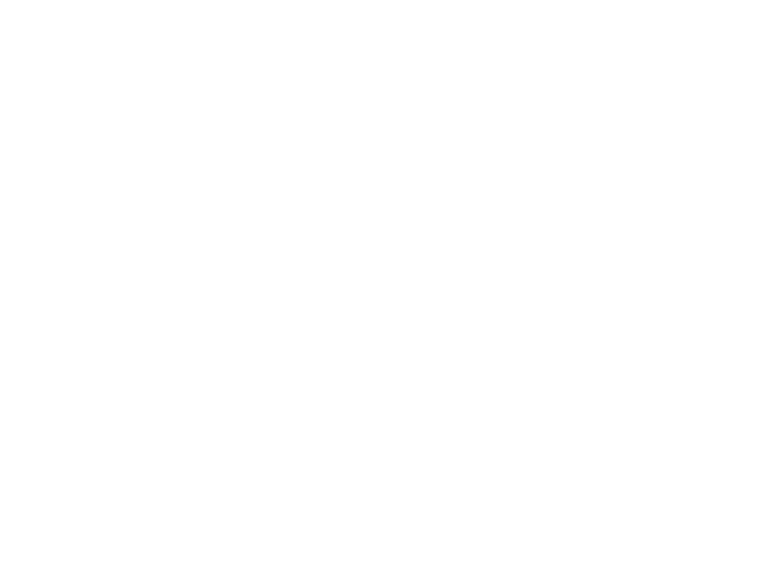

In [25]:
plt.figure()
plt.scatter(Z[y==0, 0], Z[y==0, 1], c='b', label='Setosa')
plt.scatter(Z[y==1, 0], Z[y==1, 1], c='g', label='Versicolor')
plt.scatter(Z[y==2, 0], Z[y==2, 1], c='r', label='Virginica')

plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.legend();

You may have noticed that the $z_0$ dimension (which is our dimension 0 using python 0 based indexing) is
flipped in this figure.  As mentioned in the figures, PCA can return z or the -z of a vector.  Thus, to
get exactly the same figure as we had before, we just need to negate our z vector for the first dimension.

<IPython.core.display.Javascript object>


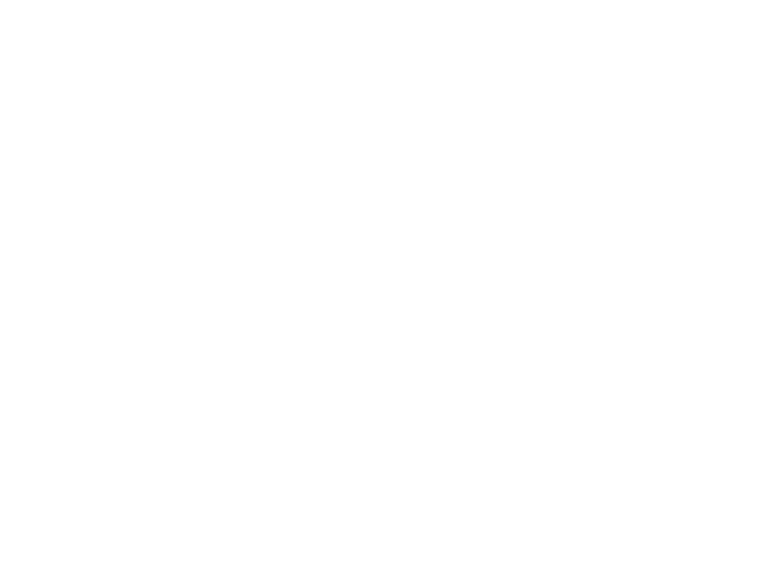

In [26]:
plt.figure()
plt.scatter(-Z[y==0, 0], Z[y==0, 1], c='b', label='Setosa')
plt.scatter(-Z[y==1, 0], Z[y==1, 1], c='g', label='Versicolor')
plt.scatter(-Z[y==2, 0], Z[y==2, 1], c='r', label='Virginica')

plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.legend();

If you look closely at this figure and compare it to the figure produced by using the `scikit-learn`
implementation of PCA, you should see that we got exactly the same result.

Also as we will later discuss, the other matrices from the SVD contain useful information.  For example, previously
we printed out the `components_` and the `explained_variance_ratio_` returned from PCA.  The `components` should
be equivalent to our $U_{reduced}$ reduced principal components matrix.  Likewise the `explained_variance_ratio_`
is the same as the $S$ vector from the SVD (normalized to sum up to 1):

```python
>>> print(pca.components_)
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
>>> print(pca.explained_variance_ratio_)
[0.92461872 0.05306648]
```

In [27]:
print(U_reduce)
print(S / np.sum(S))

[[-0.36138659 -0.65658877]
 [ 0.08452251 -0.73016143]
 [-0.85667061  0.17337266]
 [-0.3582892   0.07548102]]
[0.92461872 0.05306648 0.01710261 0.00521218]


# Video W8 10: Choosing the Number of Principal Components

[YouTube Video Link](https://www.youtube.com/watch?v=qqK-8HZjwTo&index=86&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


As shown in this video, we can use the S matrix from the singular value decomposition to see how much
variance each of the new dimensions discovered by the PCA explains.  I didn't mention it above, but we
can get the S matrix that `scikit-learn` calculates, as well as the ratio of the variance explained
by each of the Z dimensions, like this:

In [28]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[4.22824171 0.24267075]
[0.92461872 0.05306648]


The explained variance is basically the S matrix from the SVD:

In [29]:
print(S)

[4.20005343 0.24105294 0.0776881  0.02367619]


The variance ratio is simply obtained by dividing each variance measure by the total sum of the variance
measures.  

In [30]:
print(S / np.sum(S))

[0.92461872 0.05306648 0.01710261 0.00521218]


As discussed in this video, the ratio of the variances in PCA can be interpreted as the amount of
information each dimension holds.  In the case of the iris data set PCA, the first dimension explains
92.5% of the variance of the data, and the second dimension another 5.3%, for a total of almost 98%
of the variance represented by the first 2 dimensions.  Another way that I think of these measures,
the first 2 dimensions of our PCA actually only introduce about 2% of projection error when projecting
the original 4 dimensional data onto the discovered 2 principle component dimensions.

Sometimes you will see people plot the variance ratios.  This isn't too useful for our iris data with
only 4 dimensions total, but when you have a large number of dimensions, it can visually let you
know which dimensions are important, and which add little and mostly represent redundant information
or noise in the data.

<IPython.core.display.Javascript object>


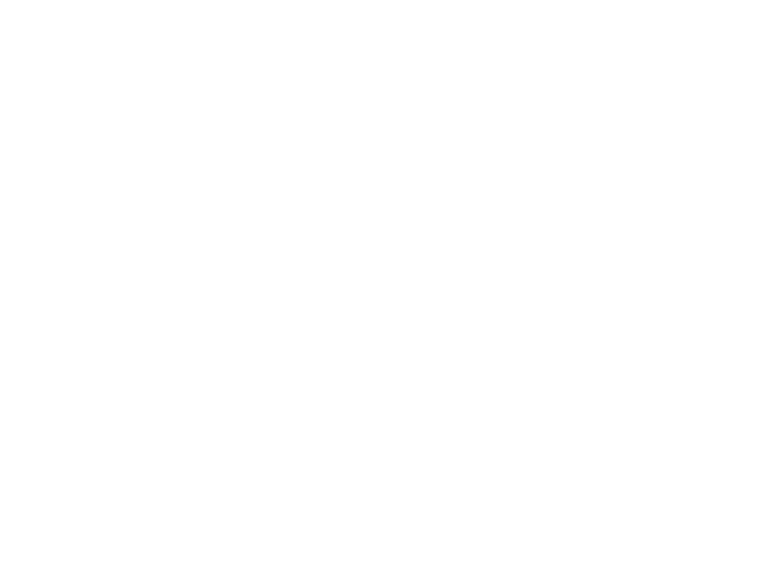

In [31]:
%matplotlib notebook
plt.plot(range(4), S/np.sum(S), 'bo')
plt.plot(range(4), S/np.sum(S), 'k--')
plt.axis([-0.5, 3.5, 0.0, 1.0])
plt.xlabel('Dimension')
plt.ylabel('Ratio of Variance Explained');

As discussed in the video, typically we choose the number of dimensions $k$ when doing reduction or compression
to retain some percentage of the variance.  Typically we might choose to retain $0.99$ or $0.95$ ratio of the
variance.  This means we need to look at the explained variance, and choose the dimension $k$ that is at or
exceeds the target.  So instead of plotting the ratio like we did before, it is often more informative to 
plot the cumulative sum of the ratio explained.

<IPython.core.display.Javascript object>


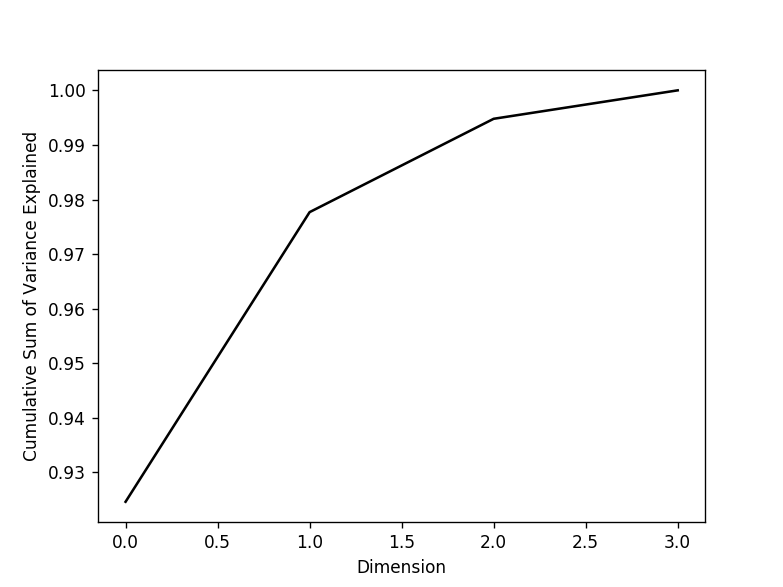

In [32]:
%matplotlib notebook

plt.plot(range(4), np.cumsum(S/np.sum(S)), 'k-')
plt.xlabel('Dimension')
plt.ylabel('Cumulative Sum of Variance Explained');

Another think to note, in practice it is often the case that a lot of dimensions are only capturing noise or are
highly correlated with other dimensions.  So often it can be surprising how many dimensions will not be needed
to retain 95% or even 99% of the variance.  Often a large number of dimensions are possible to be dropped while still
retaining a high percentage of the variance of the original data.

# Video W8 11: Reconstruction from Compressed Representation

[YouTube Video Link](https://www.youtube.com/watch?v=ATeoRX1GKVE&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=87)


So we can project back to the original high dimensional space using the information from our PCA.

\begin{equation}
X_{approx} = U_{reduce} \times Z
\end{equation}

Where $Z$ is the projected $k$ dimensional space of the samples of the data.

So we could reconstruct the 4D iris data set back from the 2D representation we showed above, though of course we
wouldn't really be able to visualize what this does.

# Video W8 12: Advice for Applying PCA

[YouTube Video Link](https://www.youtube.com/watch?v=QitS8I_Thd8&index=88&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

PCA can be used to speed up the learning time of an algorithm.  For a supervised learning problem with $m$
samples we might often have very high dimensional (big) data.  So the features of each sample could be in the 10s
or 100s of thousands of features (or even bigger).  For example when doing processing on images, each pixel
will be 1 feature (or even 3 features if doing color images).

For big data, it is often useful to use dimensionality reduction to reduce the representation to a much
lower number of dimensions.  This helps both because a) many of the low variance dimensions are just capturing
noise, and are thus not useful, if not even actively harmful, to a supervised learner in modeling the data.
Also when the data is reduced down in dimension significantly, this significantly simplifies the task that
the supervied learning mechanism must perform.

**NOTE**: The mapping of $x^{(i)} \to z^{(i)}$ should be defined by running PCA **only** on the training set.
This mapping can be applied as well to the examples in the cross-validation and test sets when needed.  But the
mapping should never be learned from the test or cv data, because if you do this you are leaking information
from your test data potentially back to your training information.

## Application of PCA

- Compression
  - Reduce memory/disk needed to store data
  - Speed up learning algorithm
- Visualization

For compression we will choose $k$ to retain some percentage of the variation in the data, typically 99% or 95%.
But for visualization, of course, the goal is to better understand the data.  So in that case we must choose to
reduce to $k=2$ or $k=3$ so we can plot a visualization of the data.

